In [1]:
import numpy as np 

from os.path import dirname, join, abspath

# import measurement 
import crocoddyl 
import matplotlib.pyplot as plt 
# add package path manually
import os
import sys
#
src_path = abspath('../../../')
sys.path.append(src_path)

src_path = abspath('../')
sys.path.append(src_path)
from cliff_diff_action import DifferentialActionModelCliff
from solvers import risc 
from utils import measurement 


MAXITER = 1000
CALLBACKS = True 
dt = 0.01 
T = 300 
x0 = np.zeros(4) 

LINE_WIDTH = 100 
sigmas = np.arange(-10,10,2)
sigmas = [-10, -8, -6, -4, -2, 0, .5, 1., 1.5, 2.]
sigmas = [-10, -8, -6, -4, -2, 0, .01, .05, .1] # .5, 1.] # 2., 4.] #, 6.]
SAVE_FIGS = True 
SAVE_PATH = '' 

In [2]:
# define basic problems 


def ddpCreateProblem(model):
    cliff_diff_running =  DifferentialActionModelCliff()
    cliff_diff_terminal = DifferentialActionModelCliff(isTerminal=True)
    cliff_running = crocoddyl.IntegratedActionModelEuler(cliff_diff_running, dt) 
    cliff_terminal = crocoddyl.IntegratedActionModelEuler(cliff_diff_terminal, dt) 
    xs = [x0]*(T+1)
    us = [np.zeros(2)]*T
    problem = crocoddyl.ShootingProblem(x0, [cliff_running]*T, cliff_terminal)
    return xs, us, problem


def riskCreateProblem(model):
    ### also add measurement models compared to ddp 
    
    cliff_diff_running =  DifferentialActionModelCliff()
    cliff_diff_terminal = DifferentialActionModelCliff(isTerminal=True)
    cliff_running = crocoddyl.IntegratedActionModelEuler(cliff_diff_running, dt) 
    cliff_terminal = crocoddyl.IntegratedActionModelEuler(cliff_diff_terminal, dt) 
    xs = [x0]*(T+1)
    us = [np.array([0., 9.81])]*T
    runningModels = [cliff_running]*T
    terminalModel = cliff_terminal
    runningMeasurements = []

    for t, process_model in enumerate(runningModels):
        state_diffusion = 5. * dt * np.eye(process_model.state.ndx)
        state_noise =  np.eye(process_model.state.ndx)
        measurement_diffusion = np.eye(process_model.state.ndx)
        measurement_noise = np.eye(process_model.state.ndx) 
        measurementMod = measurement.MeasurementModelFullState(process_model,state_diffusion, 
                    state_noise, measurement_diffusion, measurement_noise)
        runningMeasurements += [measurementMod]
    return xs, us, runningModels, terminalModel, runningMeasurements



In [3]:
# solve ddp 
ddp_xs, ddp_us, ddp_problem = ddpCreateProblem(crocoddyl.ActionModelLQR)
ddp = crocoddyl.SolverDDP(ddp_problem)
if CALLBACKS:
    ddp.setCallbacks([crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()])

ddp.solve(ddp_xs, ddp_us, MAXITER)

solvers =[ddp]
solver_names = ["ddp"]

In [4]:
for i, sig in enumerate(sigmas):
    print("Running risk sensitive with sensitivity %s".center(LINE_WIDTH,'#')%(sig))
    risk_xs, risk_us, runningModels, terminalModel, runningMeasurements = riskCreateProblem(crocoddyl.ActionModelLQR)
    riskProblem = crocoddyl.ShootingProblem(risk_xs[0], runningModels, terminalModel)
    measurementModels = measurement.MeasurementModels(runningModels, runningMeasurements)
    # print("measurement models initialized successfully ")

    riskSolver = risc.RiskSensitiveSolver(riskProblem, measurementModels, sig)
    riskSolver.callback = [crocoddyl.CallbackLogger(), crocoddyl.CallbackVerbose()]
    # print("risk solver initialized successfully ")

    riskSolver.solve(MAXITER, risk_xs, risk_us, False)
    solvers += [riskSolver]
    solver_names += ["risk %s"%sig]


#############################Running risk sensitive with sensitivity -10#############################
Data allocated succesfully
Feedforward Norm 2.4909571926860893e-10, Solver converged 
#############################Running risk sensitive with sensitivity -8#############################
Data allocated succesfully
Feedforward Norm 5.198871502399666e-10, Solver converged 
#############################Running risk sensitive with sensitivity -6#############################
Data allocated succesfully
Feedforward Norm 3.797606672879961e-11, Solver converged 
#############################Running risk sensitive with sensitivity -4#############################
Data allocated succesfully
Feedforward Norm 5.7377867401016653e-11, Solver converged 
#############################Running risk sensitive with sensitivity -2#############################
Data allocated succesfully
Feedforward Norm 4.906465078530652e-11, Solver converged 
#############################Running risk sensitive with sensitivit

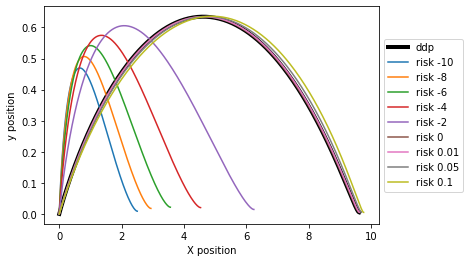

In [5]:
# plot state trajectory 
time_array = dt*np.arange(np.array(ddp.xs).shape[0])

plt.figure("State_Trajectory")
for i, solver in enumerate(solvers): 
    if "ddp" in solver_names[i]:
        plt.plot(np.array(solver.xs)[:,0], np.array(solver.xs)[:,1], 'k', linewidth=4., label=solver_names[i])
    else:
        plt.plot(np.array(solver.xs)[:,0], np.array(solver.xs)[:,1], label=solver_names[i])
        
plt.legend(loc="center left", bbox_to_anchor=(1., .5), ncol= 1)
plt.xlabel('X position')
plt.ylabel('y position')
# plt.axes().set_aspect('equal', 'datalim')
if SAVE_FIGS:
    plt.savefig(SAVE_PATH+'state_trajectory.png')

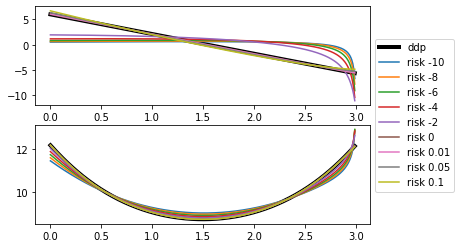

In [6]:
# plot feed forward controls 
fig, ax = plt.subplots(2, 1)
for i in range(2):
    for k, solver in enumerate(solvers): 
        if "ddp" in solver_names[k]:
            ax[i].plot(time_array[:-1], np.array(solver.us)[:,i],  'k',linewidth=4., label=solver_names[k])
        else:
            ax[i].plot(time_array[:-1], np.array(solver.us)[:,i], label=solver_names[k])
        

ax[0].legend(loc="center left", bbox_to_anchor=(1., -.1), ncol= 1)
#     ax[i].grid()
if SAVE_FIGS:
    plt.savefig(SAVE_PATH+'control_trajectory.png')

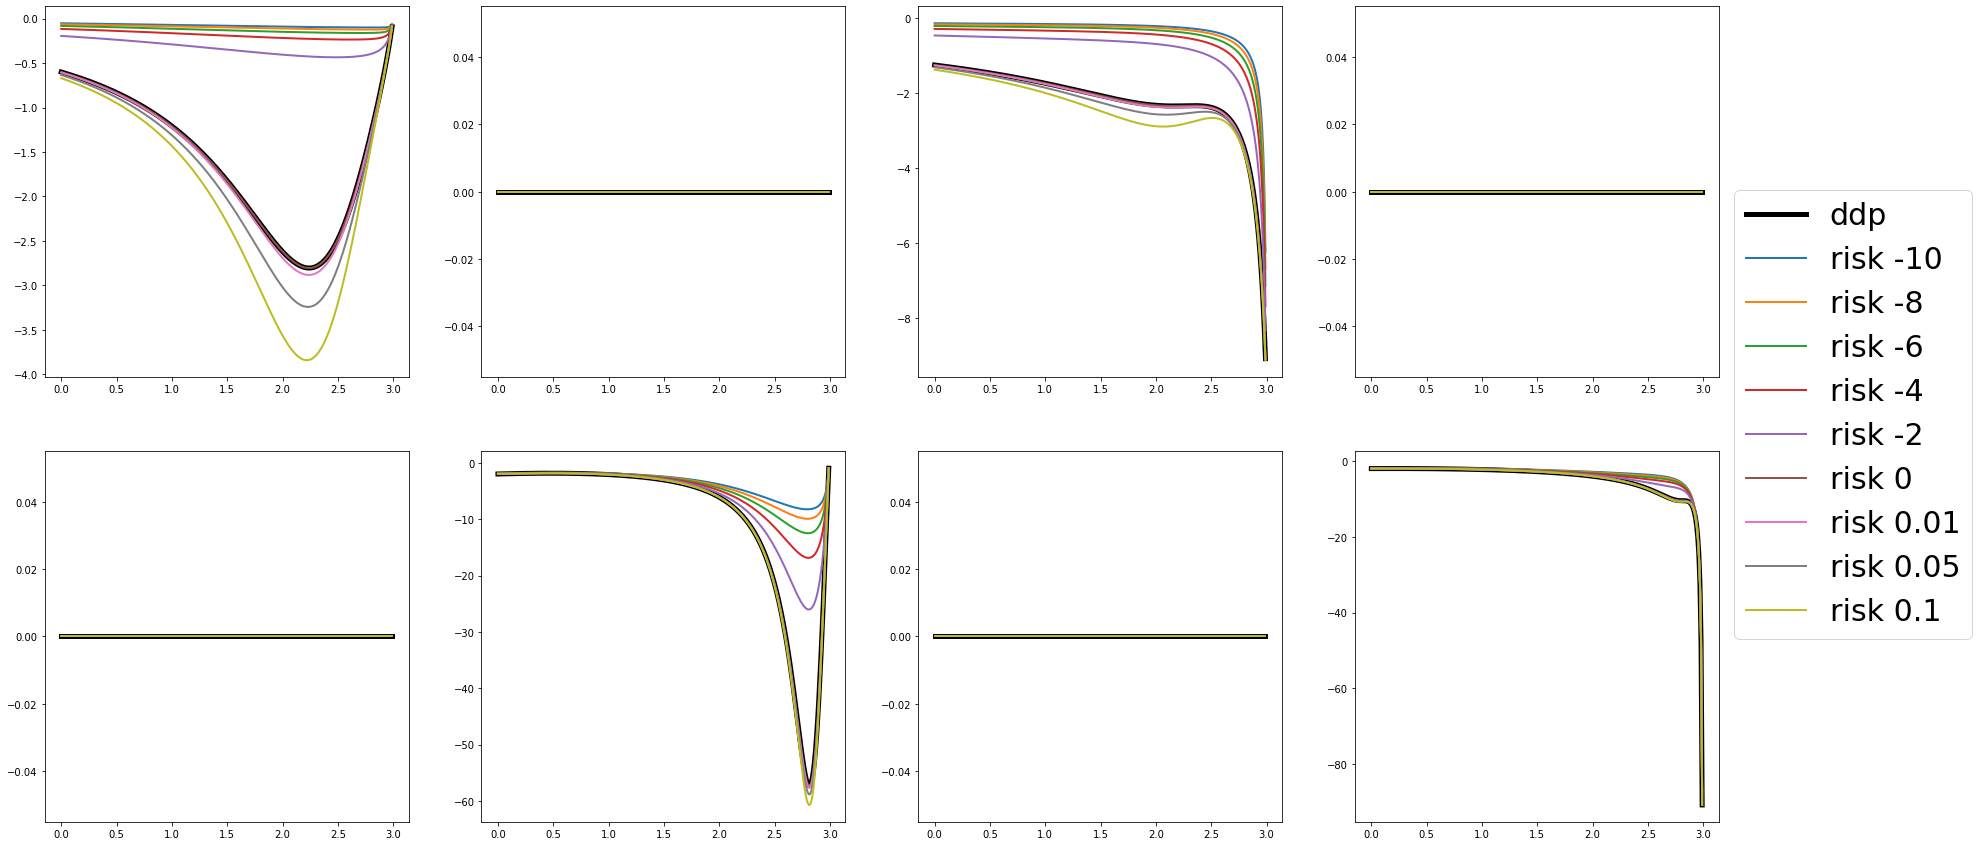

In [7]:
plt.rc('legend', fontsize=30)    # legend fontsize
fig, ax = plt.subplots(2, 4,figsize=(30,15))

for i in range(2):
    for j in range(4): 
        for k, solver in enumerate(solvers): 
            if "ddp" in solver_names[k]:
                ax[i,j].plot(time_array[:-1], -np.array(solver.K)[:,i,j], 'k', linewidth=5., label=solver_names[k])
            else:
                ax[i,j].plot(time_array[:-1], np.array(solver.K)[:,i,j],linewidth=2., label=solver_names[k])
ax[0,3].legend(loc="center left", bbox_to_anchor=(1., -.1), ncol= 1)
if SAVE_FIGS:
    plt.savefig(SAVE_PATH+'feedback_trajectory.png')